In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Function to calculate future peak price
def calculate_future_peak(df, k):
    return df['high'].rolling(window=k, min_periods=1).max().shift(-k)

Let me break down this line of code step by step:

```python
df['high'].rolling(window=k, min_periods=1).max().shift(-k)
```

1. `df['high']`: This selects the 'high' column from a pandas DataFrame. This column likely contains price/value highs for each period.

2. `.rolling(window=k, min_periods=1)`:
   - Creates a rolling window of size `k` over the data
   - `window=k` means it looks at `k` rows at a time
   - `min_periods=1` means the window will start calculating as soon as there is at least 1 valid value (instead of waiting for the window to be completely filled)
   - For example, if k=3, at each point it looks at the current value and the next 2 values

3. `.max()`:
   - Calculates the maximum value within each rolling window
   - For k=3, it would find the highest value among each group of 3 rows

4. `.shift(-k)`:
   - Shifts the resulting series up by k positions
   - The negative sign means it shifts upward (brings future values earlier)
   - This aligns the maximum values with the start of their respective windows

Here's a simple example:
```python
# If df['high'] contains: [10, 15, 12, 18, 14] and k=2
# After rolling().max(): [15, 15, 18, 18, 14]
# After shift(-2):      [18, 18, 14, NaN, NaN]
```

This code is commonly used in technical analysis to find future maximum prices within a given window, often for calculating resistance levels or identifying potential future highs. Would you like me to explain any part in more detail?

In [ ]:
# Function to dynamically generate labels from percentage change
def assign_labels(percentage_change):
    # Cap the percentage change to be within the range -10 to +10
    if percentage_change < -10.0:
        percentage_change = -10.0
    elif percentage_change > 10.0:
        percentage_change = 10.0

    # Round the percentage change to 1 decimal place
    rounded_pct = round(percentage_change, 1)
    
    # Format the label string based on the rounded percentage
    if rounded_pct < 0:
        label = f"MINUS_{str(rounded_pct).replace('-', '').replace('.', '_')}"
    else:
        label = f"PLUS_{str(rounded_pct).replace('.', '_')}"
    
    return label

Let me break down this function step by step:

```python
def assign_labels(percentage_change):
```
This function takes a single parameter `percentage_change`, which represents a percentage value (like +5.7% or -3.2%).

1. Capping the Values:
```python
if percentage_change < -10.0:
    percentage_change = -10.0
elif percentage_change > 10.0:
    percentage_change = 10.0
```
- Ensures the percentage change stays within -10% to +10%
- Any value below -10% becomes -10%
- Any value above +10% becomes +10%

2. Rounding:
```python
rounded_pct = round(percentage_change, 1)
```
- Rounds the percentage to 1 decimal place
- Example: 5.768% becomes 5.8%

3. Label Formation:
```python
if rounded_pct < 0:
    label = f"MINUS_{str(rounded_pct).replace('-', '').replace('.', '_')}"
else:
    label = f"PLUS_{str(rounded_pct).replace('.', '_')}"
```
- For negative numbers:
  - Removes the minus sign
  - Replaces decimal point with underscore
  - Adds "MINUS_" prefix
  - Example: -5.8 becomes "MINUS_5_8"

- For positive numbers:
  - Replaces decimal point with underscore
  - Adds "PLUS_" prefix
  - Example: 5.8 becomes "PLUS_5_8"

Examples of the function's output:
```python
assign_labels(5.768)    # Returns "PLUS_5_8"
assign_labels(-3.2)     # Returns "MINUS_3_2"
assign_labels(15.0)     # Returns "PLUS_10_0" (capped at 10)
assign_labels(-12.5)    # Returns "MINUS_10_0" (capped at -10)
```

This function appears to be used for creating standardized string labels from percentage changes, possibly for classification or categorization purposes in a machine learning or data analysis context. Would you like me to elaborate on any part?

In [3]:


# Function to generate labels for a sliding window of N candles
def generate_labels(df_raw, N, K):
    df = df_raw.copy()

    # Calculate the future peak price within K candles for each row
    df['future_peak'] = calculate_future_peak(df, K)
    
    # Calculate the median and standard deviation for the sliding window of N candles
    rolling_median = df['close'].rolling(window=N).median()
    rolling_std = df['close'].rolling(window=N).std()

    # Calculate the baseline as the median minus 4 times the standard deviation
    df['baseline'] = rolling_median - 4 * rolling_std
    
    # Calculate the percentage change between the baseline and the future peak price
    df['pct_change'] = (df['future_peak'] - df['baseline']) / df['baseline'] * 100
    
    # Assign labels based on percentage change
    df['label'] = df['pct_change'].apply(assign_labels)
    
    # Drop any rows with missing values due to rolling/shift operations
    df = df.dropna(subset=['future_peak', 'pct_change', 'baseline'])

    # Return the dataframe with the labels
    return df[['open', 'high', 'low', 'close', 'baseline', 'label']]

Let me break down this function that generates labels based on price movement patterns:

```python
def generate_labels(df_raw, N, K):
```
The function takes 3 parameters:
- `df_raw`: A DataFrame with OHLC (Open, High, Low, Close) price data
- `N`: Size of the sliding window for calculating statistics
- `K`: Number of future candles to look ahead for peak price

Let's go through each step:

1. Creating a Working Copy:
```python
df = df_raw.copy()
```
- Makes a copy to avoid modifying the original data

2. Calculating Future Peak:
```python
df['future_peak'] = calculate_future_peak(df, K)
```
- For each row, finds the highest price in the next K candles
- Uses the `calculate_future_peak` function (which we saw earlier uses rolling max and shift)

3. Statistical Calculations:
```python
rolling_median = df['close'].rolling(window=N).median()
rolling_std = df['close'].rolling(window=N).std()
```
- Calculates two rolling statistics over N candles:
  - Median closing price
  - Standard deviation of closing price

4. Baseline Price Calculation:
```python
df['baseline'] = rolling_median - 4 * rolling_std
```
- Sets a baseline price as: median - (4 × standard deviation)
- This creates a dynamic lower boundary that adapts to market volatility

5. Percentage Change Calculation:
```python
df['pct_change'] = (df['future_peak'] - df['baseline']) / df['baseline'] * 100
```
- Calculates how much the future peak price rises above the baseline
- Formula: ((future_peak - baseline) / baseline) × 100

6. Label Assignment:
```python
df['label'] = df['pct_change'].apply(assign_labels)
```
- Uses the `assign_labels` function we discussed earlier
- Converts percentage changes into categorical labels like "PLUS_5_8" or "MINUS_3_2"

7. Cleanup and Return:
```python
df = df.dropna(subset=['future_peak', 'pct_change', 'baseline'])
return df[['open', 'high', 'low', 'close', 'baseline', 'label']]
```
- Removes rows with missing values
- Returns only the essential columns

This function appears to be part of a trading strategy or analysis system that:
1. Establishes a dynamic baseline price using statistical measures
2. Looks ahead K candles to find peak prices
3. Measures the percentage rise from baseline to future peak
4. Converts these movements into categorical labels

This could be used for:
- Creating training data for machine learning models
- Identifying potential trading opportunities
- Analyzing price movement patterns

Would you like me to elaborate on any particular aspect?

## Tying it together

Yes, I can explain how these three functions work together. They appear to be part of a system that labels price patterns for potential trading opportunities or machine learning training data. Let me break down their interaction:

1. `generate_labels` is the main orchestrating function:
```python
def generate_labels(df_raw, N, K):
    # First calls calculate_future_peak
    df['future_peak'] = calculate_future_peak(df, K)
    
    # ... calculates baseline using statistics ...
    
    # Then calls assign_labels
    df['label'] = df['pct_change'].apply(assign_labels)
```

2. `calculate_future_peak` looks forward:
```python
# Looking K candles ahead for the highest price
return df['high'].rolling(window=k, min_periods=1).max().shift(-k)
```

3. `assign_labels` categorizes the moves:
```python
def assign_labels(percentage_change):
    # Caps moves at ±10%
    # Creates labels like "PLUS_5_8" or "MINUS_3_2"
```

### The overall purpose appears to be:

1. Pattern Recognition:
   - For each point in time, it establishes a baseline price using median and standard deviation
   - Looks ahead K candles to find the highest price
   - Measures how much price rises above the baseline

2. Label Generation:
   - Converts these price movements into discrete categories
   - Labels are standardized (e.g., "PLUS_5_8" for 5.8% rise)
   - Movements are capped at ±10%

3. Likely Applications:
   - Creating training data for machine learning models
   - The labels could be used to:
     - Predict future price movements
     - Identify potential buying opportunities
     - Spot patterns that lead to significant price increases

Example Flow:
```
Starting with price data:
[100, 102, 98, 105, 110, 108, 115]

1. calculate_future_peak looks ahead K candles:
   - For K=3, at price 100, it sees [102, 98, 105]
   - Records the peak (105)

2. generate_labels calculates baseline:
   - Uses median and std dev to set dynamic threshold
   - Let's say baseline is 95

3. assign_labels categorizes the move:
   - ((105 - 95) / 95) * 100 = 10.5%
   - Capped at 10%
   - Becomes "PLUS_10_0"
```

This system seems designed for:
1. Automated Trading: Identifying potential entry points
2. Pattern Analysis: Understanding what price patterns lead to significant moves
3. Machine Learning: Creating labeled data for predictive models
4. Risk Management: Using statistical measures to set baselines

Would you like me to elaborate on any particular aspect of how these functions interact?

In [ ]:
df_raw = pd.read_parquet('./desiquant_AMBUJACEM.parquet')
df_raw.head(6)

In [11]:
df_small = df_raw[45000:48000]
df_small.head(3)

In [13]:
# Example usage
N = 100  # Number of candles in history window
K = 5   # Number of candles in future for peak price

# Assuming df_raw has your stock price data
df_labeled = generate_labels(df_raw, N, K)

In [ ]:
calculate_future_peak(df_small, 10)

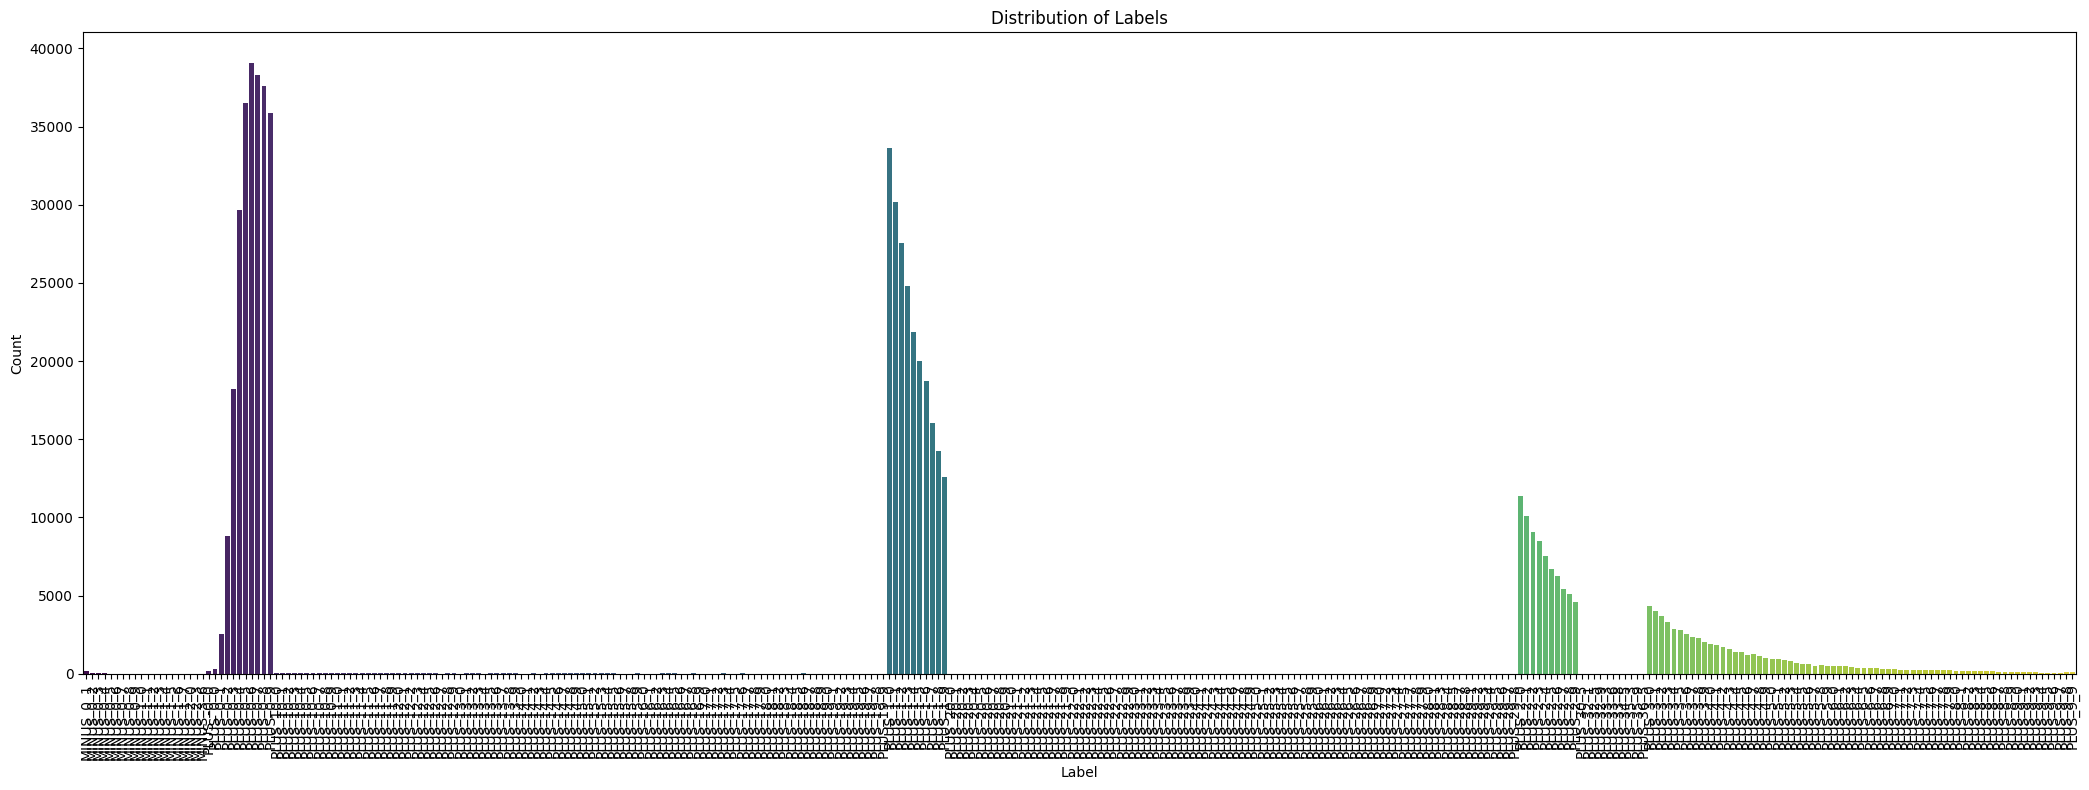

In [15]:
plt.figure(figsize=(21, 8))

# Count the occurrences of each label
label_counts = df_labeled['label'].value_counts().sort_index()

# Create a bar plot for label distribution
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent label clipping

# Show the plot
plt.show()

In [19]:
df_labeled.to_csv("./aaa.csv", float_format='%.3f', index=False)

## Going further - next steps

> suppose these functions are applied to a bunch of OHLC datasets. how can the resulting dataframes be used for automated trading using machine learning? 
answer elaborately.

Let me explain how these labeled OHLC datasets could be used for machine learning-based automated trading systems.

1. Data Preparation and Feature Engineering:
```python
def prepare_features(df):
    # Technical indicators
    df['rsi'] = calculate_rsi(df['close'])
    df['macd'] = calculate_macd(df['close'])
    df['bb_upper'], df['bb_lower'] = calculate_bollinger_bands(df['close'])
    
    # Price patterns
    df['candle_size'] = df['high'] - df['low']
    df['body_size'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # Volume analysis
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    
    # Price momentum
    df['returns'] = df['close'].pct_change()
    df['volatility'] = df['returns'].rolling(window=20).std()
    
    return df

# Split into features (X) and labels (y)
X = feature_df[['rsi', 'macd', 'bb_upper', 'bb_lower', ...]]
y = df['label']  # From our generate_labels function
```

2. Training Process:

```python
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Example classifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
model = XGBClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=1000,
    objective='multi:softprob'
)
model.fit(X_train, y_train)
```

3. Trading Strategy Implementation:

```python
class MLTradingStrategy:
    def __init__(self, model, risk_per_trade=0.02):
        self.model = model
        self.risk_per_trade = risk_per_trade
        
    def analyze_market(self, current_data):
        # Prepare features for current market data
        features = prepare_features(current_data)
        latest_features = features.iloc[-1]
        
        # Get model prediction
        prediction = self.model.predict_proba([latest_features])[0]
        
        # Extract predicted movement
        predicted_label = self.model.classes_[prediction.argmax()]
        confidence = prediction.max()
        
        return predicted_label, confidence
    
    def calculate_position_size(self, account_size, entry_price, stop_loss):
        risk_amount = account_size * self.risk_per_trade
        price_risk = abs(entry_price - stop_loss)
        position_size = risk_amount / price_risk
        return position_size
    
    def execute_trade(self, predicted_label, confidence, current_price, account_size):
        # Only trade if confidence exceeds threshold
        if confidence < 0.75:
            return None
            
        # Extract predicted movement from label
        movement = float(predicted_label.split('_')[1].replace('_', '.'))
        direction = 1 if 'PLUS' in predicted_label else -1
        
        if direction == 1:  # Long trade
            entry_price = current_price
            stop_loss = entry_price * 0.98  # 2% stop loss
            target_price = entry_price * (1 + movement/100)
            
            position_size = self.calculate_position_size(
                account_size, entry_price, stop_loss
            )
            
            return {
                'action': 'BUY',
                'size': position_size,
                'entry': entry_price,
                'stop_loss': stop_loss,
                'target': target_price,
                'confidence': confidence
            }
```

4. Real-time Trading System:

```python
class TradingSystem:
    def __init__(self, strategy, broker_api):
        self.strategy = strategy
        self.broker = broker_api
        self.active_trades = {}
        
    async def monitor_market(self):
        while True:
            # Get latest market data
            current_data = await self.broker.get_market_data()
            
            # Update features and get prediction
            predicted_label, confidence = self.strategy.analyze_market(current_data)
            
            # Check for trade signals
            trade_signal = self.strategy.execute_trade(
                predicted_label,
                confidence,
                current_data['close'].iloc[-1],
                self.broker.get_account_size()
            )
            
            if trade_signal:
                # Execute trade
                order = await self.broker.place_order(
                    symbol=trade_signal['symbol'],
                    side=trade_signal['action'],
                    quantity=trade_signal['size'],
                    stop_loss=trade_signal['stop_loss'],
                    take_profit=trade_signal['target']
                )
                
                self.active_trades[order.id] = trade_signal
                
            # Monitor existing trades
            await self.manage_trades()
            
            await asyncio.sleep(60)  # Check every minute
            
    async def manage_trades(self):
        for trade_id, trade in self.active_trades.items():
            # Get current position status
            position = await self.broker.get_position(trade_id)
            
            # Implement trailing stops or adjust targets based on predictions
            new_stop = self.calculate_trailing_stop(
                position.entry_price,
                position.current_price,
                trade['initial_stop']
            )
            
            if new_stop != trade['current_stop']:
                await self.broker.modify_order(
                    trade_id,
                    new_stop_loss=new_stop
                )
```

5. Risk Management and Position Sizing:
```python
class RiskManager:
    def __init__(self, max_open_trades=3, max_correlation=0.7):
        self.max_open_trades = max_open_trades
        self.max_correlation = max_correlation
        
    def validate_trade(self, new_trade, existing_trades, market_data):
        # Check number of open trades
        if len(existing_trades) >= self.max_open_trades:
            return False
            
        # Check correlation with existing positions
        correlations = self.calculate_correlations(
            new_trade['symbol'],
            [t['symbol'] for t in existing_trades],
            market_data
        )
        
        if max(correlations) > self.max_correlation:
            return False
            
        return True
```

Key Aspects of this System:

1. Feature Engineering:
   - Technical indicators
   - Price patterns
   - Volume analysis
   - Market microstructure

2. Model Training:
   - Multiple timeframe analysis
   - Cross-validation
   - Hyperparameter optimization
   - Regular retraining

3. Trading Rules:
   - Confidence thresholds
   - Position sizing
   - Risk management
   - Stop loss and take profit levels

4. System Management:
   - Portfolio correlation
   - Maximum drawdown controls
   - Trading costs consideration
   - Performance monitoring

Would you like me to elaborate on any particular component of this system?

## Dealing with imbalanced labels

> how to deal with a skewed dataset where, say, PLUS_4_8 is much more common than e.g. PLUS_7_5?



Here are several approaches to handle class imbalance in the trading dataset:

1. Resampling Techniques:

```python
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

def balance_dataset(X, y):
    # Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Method 2: Combined Over and Under Sampling
    combined = SMOTETomek(random_state=42)
    X_balanced, y_balanced = combined.fit_resample(X, y)
    
    return X_balanced, y_balanced

# Check class distribution before and after
def check_distribution(y_orig, y_balanced):
    print("Original distribution:")
    print(y_orig.value_counts(normalize=True))
    print("\nBalanced distribution:")
    print(y_balanced.value_counts(normalize=True))
```

2. Class Weights:

```python
from sklearn.utils.class_weight import compute_class_weight

def train_weighted_model(X, y):
    # Calculate weights inversely proportional to class frequencies
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    
    # Create weight dictionary
    weight_dict = dict(zip(np.unique(y), class_weights))
    
    # Train model with weights
    model = XGBClassifier(
        scale_pos_weight=weight_dict,  # For binary classification
        # Or use sample_weight parameter during fit for multiclass
    )
    
    # For multiclass, use sample weights
    sample_weights = [weight_dict[label] for label in y]
    model.fit(X, y, sample_weight=sample_weights)
    
    return model
```

3. Stratified Sampling:

```python
def create_balanced_folds(X, y, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Now each fold maintains the same class distribution as the original dataset
```

4. Custom Loss Function:

```python
def weighted_cross_entropy(y_true, y_pred):
    # Example for binary classification
    # Adjust weights based on class frequencies
    weights = tf.where(tf.equal(y_true, 1), 
                      tf.constant(0.7),  # Weight for minority class
                      tf.constant(0.3))  # Weight for majority class
    
    return tf.reduce_mean(
        weights * tf.keras.losses.binary_crossentropy(y_true, y_pred)
    )

# For XGBoost
def custom_objective(y_true, y_pred):
    # Calculate gradients and hessians with class-specific weights
    classes, counts = np.unique(y_true, return_counts=True)
    weights = dict(zip(classes, 1/counts))
    
    grad = (y_pred - y_true) * [weights[y] for y in y_true]
    hess = np.ones_like(y_pred)
    
    return grad, hess
```

5. Ensemble Methods:

```python
class BalancedEnsemble:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
    
    def fit(self, X, y):
        for i in range(self.n_models):
            # Create balanced subset
            X_subset, y_subset = self.create_balanced_subset(X, y)
            
            # Train model on balanced subset
            model = XGBClassifier()
            model.fit(X_subset, y_subset)
            
            self.models.append(model)
    
    def predict_proba(self, X):
        # Average predictions from all models
        predictions = np.zeros((X.shape[0], len(self.classes_)))
        
        for model in self.models:
            predictions += model.predict_proba(X)
            
        return predictions / len(self.models)
    
    def create_balanced_subset(self, X, y):
        # Undersample majority classes and oversample minority classes
        sampler = SMOTETomek(random_state=np.random.randint(0, 1000))
        return sampler.fit_resample(X, y)
```

6. Evaluation Metrics:

```python
def evaluate_imbalanced_model(y_true, y_pred, y_prob):
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    # Classification report with per-class metrics
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    print(confusion_matrix(y_true, y_pred))
    
    # Area under Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    auc_pr = average_precision_score(y_true, y_prob)
    
    return {
        'precision': precision,
        'recall': recall,
        'auc_pr': auc_pr
    }
```

7. Trading Strategy Adjustment:

```python
class ImbalancedAwareTradingStrategy:
    def __init__(self, model, class_frequencies):
        self.model = model
        self.class_frequencies = class_frequencies
        
    def adjust_confidence_threshold(self, predicted_label):
        # Require higher confidence for common patterns
        base_threshold = 0.75
        frequency = self.class_frequencies[predicted_label]
        
        # Adjust threshold based on class frequency
        adjusted_threshold = base_threshold + (frequency - 0.5) * 0.2
        return min(0.95, adjusted_threshold)
    
    def execute_trade(self, predicted_label, confidence, current_price):
        # Get adjusted threshold for this pattern
        threshold = self.adjust_confidence_threshold(predicted_label)
        
        if confidence < threshold:
            return None
            
        # Rest of trade execution logic...
```

These approaches can be used individually or in combination. The best solution often depends on:
1. The degree of imbalance
2. The total amount of data available
3. The importance of different types of errors
4. Computational resources available
5. Real-time requirements of the trading system

Would you like me to elaborate on any of these approaches?